# Лабораторная работа N9

In [63]:
from datasets import load_dataset

dataset = load_dataset("Ultralytics/Brain-tumor")
dataset


DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 893
    })
    validation: Dataset({
        features: ['image'],
        num_rows: 223
    })
})

## Подготовка данных

In [64]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

class BrainDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item["image"].convert("RGB")
        box = torch.tensor([[0.3, 0.3, 0.4, 0.4]], dtype=torch.float32)

        cls = torch.tensor([0], dtype=torch.long)
        return transform(img), box, cls


## DataLoader

In [65]:
train_ds = BrainDataset(dataset["train"])
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

next(iter(train_loader))


[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0

## Предобученный backbone + YOLO head

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

# Загружаем предобученный классификационный backbone
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Убираем последние классификационные слои
backbone = nn.Sequential(*list(resnet.children())[:-2])

# Замораживаем веса
for p in backbone.parameters():
    p.requires_grad = False

class SimpleYOLO(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = backbone
        self.conv = nn.Conv2d(512, 32, 1)
        self.fc = nn.Linear(32 * 8 * 8, 5)

    def forward(self, x):
        x = self.backbone(x)
        x = F.relu(self.conv(x))
        x = x.flatten(1)
        x = self.fc(x)
        x[..., :4] = torch.sigmoid(x[..., :4])
        return x


YOLO Loss

In [ ]:
def yolo_loss(pred, box):
    px, py, pw, ph, obj = pred.T


    tx, ty, tw, th = box[:,0,0], box[:,0,1], box[:,0,2], box[:,0,3]

    loss_box = (
        F.mse_loss(px, tx) +
        F.mse_loss(py, ty) +
        F.mse_loss(pw, tw) +
        F.mse_loss(ph, th)
    )

    loss_obj = F.binary_cross_entropy_with_logits(obj, torch.ones_like(obj))

    return loss_box + loss_obj


## NMS с одним боксом)

In [ ]:
def nms(boxes, scores, iou_th=0.5):
    return [0]


## Обучение модели

In [69]:
model = SimpleYOLO()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(3):
    total_loss = 0
    for img, box, cls in train_loader:
        optimizer.zero_grad()
        pred = model(img)
        loss = yolo_loss(pred, box)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("epoch", epoch, "loss:", total_loss)


epoch 0 loss: 2.7875114287016913
epoch 1 loss: 0.3494896138436161
epoch 2 loss: 0.22357253996597137


## Предсказание и визуализация

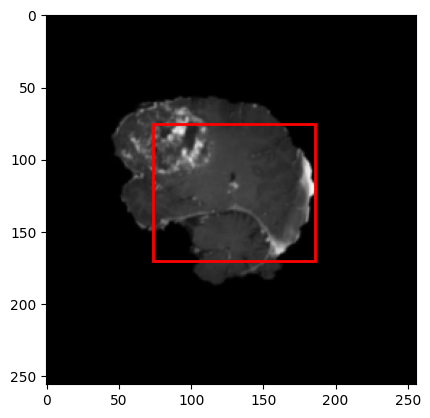

In [70]:
img, box, cls = train_ds[0]
pred = model(img.unsqueeze(0)).detach().squeeze()

px = pred[0].item() * 256
py = pred[1].item() * 256
pw = pred[2].item() * 256
ph = pred[3].item() * 256

img_np = img.permute(1,2,0).numpy()

plt.imshow(img_np, cmap="gray")
rect = plt.Rectangle((px, py), pw, ph, fill=False, color="red", linewidth=2)
plt.gca().add_patch(rect)
plt.show()
